In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("./data/Online Retail Data Set.csv", encoding = "unicode_escape")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Data Wrangling

## Null Value, Duplicates Removal and Dates Info Extraction

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

From the above, we can see that the dataset contains a good amount of nodata but only prevalent among two features `Description` and `CustomerID`. These two features are seemingly unimportant for developing the machine learning algorithm, so it won't be included for training or inference. As for this, we can avoid droping the null values and fill the rows with `unknown` and `0` respectively.

In [6]:
#dealing with the missing value in our main data
df['Description'] = df['Description'].fillna("Unknown")
df['CustomerID'] = df['CustomerID'].fillna(0)

Converting the features into proper data format

In [7]:
print(f"Total duplicate values: {df.duplicated().sum()}")

Total duplicate values: 5268


It is showing that the dataframe contain 5268 duplucate rows. We can delete them as the whole row is duplicate.

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)
df['Quantity'] = pd.to_numeric(df['Quantity'])
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'])
df['CustomerID'] = pd.to_numeric(df['CustomerID'])

In [10]:
#creating a separate column for time
df['Time'] = df['InvoiceDate'].dt.time
#creating a separate column for month
df['Month'] = df['InvoiceDate'].dt.month_name()
#creating a separate column for day name
df['Day'] = df['InvoiceDate'].dt.day_name()
#creating a column for year
df['Year']= df['InvoiceDate'].dt.year
# Get date as a format
df['date'] = pd.to_datetime(df['InvoiceDate']).dt.date.astype('datetime64[ns]')

In [11]:
df[df['Description'].str.contains('debt', case=False)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Time,Month,Day,Year,date
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,0.0,United Kingdom,14:50:00,August,Friday,2011,2011-08-12
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,0.0,United Kingdom,14:51:00,August,Friday,2011,2011-08-12
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,0.0,United Kingdom,14:52:00,August,Friday,2011,2011-08-12


These are debt which are not required, so we remove them.

In [12]:
mask = df['Description'].str.contains('debt', case=False)
# Invert mask and use boolean indexing to filter out rows
df = df[~mask]

In [13]:
df.reset_index(drop=True, inplace=True)

## Outlier Detection

<Axes: ylabel='UnitPrice'>

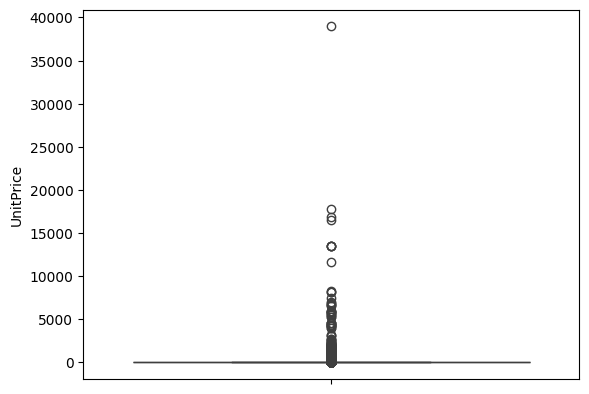

In [14]:
sns.boxplot(y = 'UnitPrice', data=df)

There are some negative values in `unitPrice` feature and we need to avoid them

In [15]:
df = df[df['UnitPrice'] > 0]
df.reset_index(inplace=True, drop=True)

<Axes: ylabel='Quantity'>

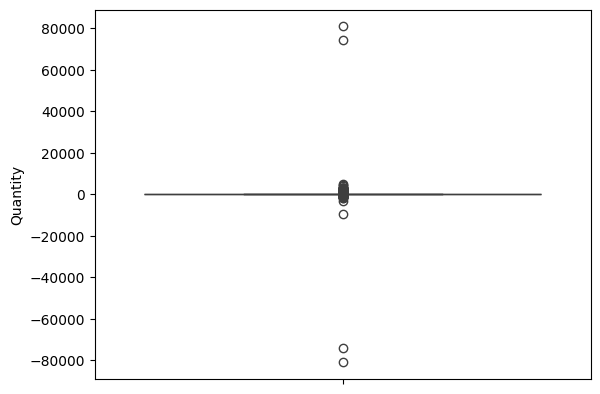

In [16]:
sns.boxplot(y = 'Quantity', data=df)

Again, the negatives should be removed from `Quantity`

In [17]:
df = df[df['Quantity'] > 0]
df.reset_index(inplace=True, drop=True)

### Outlier Detection

#### Using IsolationForest

In [21]:
from sklearn.ensemble import IsolationForest

out_df = df.copy()

In [22]:
out_df = out_df[['Quantity', 'UnitPrice']]

In [23]:
if_model=IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.1), max_features=1.0)
if_model.fit(out_df)

IsolationForest(contamination=0.1, n_estimators=150)

In [24]:
scores=if_model.decision_function(out_df)
anomaly=if_model.predict(out_df)

In [25]:
out_df.loc[:, 'scores']=scores
out_df.loc[:, 'anomaly']=anomaly

out_df.head()

,Quantity,UnitPrice,scores,anomaly
0,6,2.55,0.125738,1
1,6,3.39,0.111843,1
2,8,2.75,0.105366,1
3,6,3.39,0.111843,1
4,6,3.39,0.111843,1


In [26]:
out_df['anomaly'].value_counts()

anomaly
 1    472430
-1     52447
Name: count, dtype: int64

Isolation Forest Model infered that there are `52475` entities of anomaly available. We will compare model performance with and without anomalies

In [27]:
out_df.to_csv("./data/outlier_df.csv", index=False)

# Exploratory Data Analysis

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524877 entries, 0 to 524876
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    524877 non-null  object        
 1   StockCode    524877 non-null  object        
 2   Description  524877 non-null  object        
 3   Quantity     524877 non-null  int64         
 4   InvoiceDate  524877 non-null  datetime64[ns]
 5   UnitPrice    524877 non-null  float64       
 6   CustomerID   524877 non-null  float64       
 7   Country      524877 non-null  object        
 8   Time         524877 non-null  object        
 9   Month        524877 non-null  object        
 10  Day          524877 non-null  object        
 11  Year         524877 non-null  int32         
 12  date         524877 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int32(1), int64(1), object(7)
memory usage: 50.1+ MB


In [19]:
df['Total_sales'] = df['Quantity'] * df['UnitPrice']

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Time,Month,Day,Year,date,Total_sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,20.34


## Daily transaction trend

In [21]:
grouped_date = df.groupby("date").agg({"Quantity": np.sum, "InvoiceNo": pd.Series.nunique}).reset_index()
grouped_date

/tmp/ipykernel_18215/1324204083.py:1: FutureWarning: The provided callable <function sum at 0x78a3e1160900> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  grouped_date = df.groupby("date").agg({"Quantity": np.sum, "InvoiceNo": pd.Series.nunique}).reset_index()


,date,Quantity,InvoiceNo
0,2010-12-01,26818,127
1,2010-12-02,31264,142
2,2010-12-03,16158,68
3,2010-12-05,16242,88
4,2010-12-06,21619,102
...,...,...,...
300,2011-12-05,44497,127
301,2011-12-06,30377,115
302,2011-12-07,41789,106
303,2011-12-08,35010,120


<Axes: xlabel='date'>

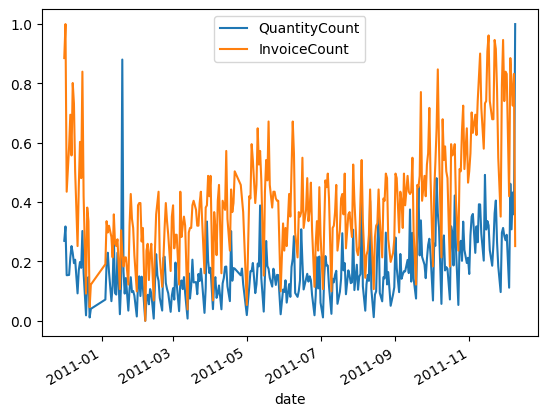

In [22]:
grouped_date['QuantityCount'] = (grouped_date['Quantity'] - grouped_date['Quantity'].min()) / (grouped_date['Quantity'].max() - grouped_date['Quantity'].min())
grouped_date['InvoiceCount'] = (grouped_date['InvoiceNo'] - grouped_date['InvoiceNo'].min()) / (grouped_date['InvoiceNo'].max() - grouped_date['InvoiceNo'].min())
ax = plt.gca()
grouped_date.plot( x = 'date' , y = 'QuantityCount', ax = ax )
grouped_date.plot( x = 'date' , y = 'InvoiceCount' , ax = ax )

In [27]:
grouped_day = df.groupby("Day").agg({"Quantity": np.sum, "InvoiceNo": pd.Series.nunique}).reset_index()
grouped_day

/tmp/ipykernel_13421/3045427193.py:1: FutureWarning: The provided callable <function sum at 0x77ec3d1347c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  grouped_day = df.groupby("Day").agg({"Quantity": np.sum, "InvoiceNo": pd.Series.nunique}).reset_index()


,Day,Quantity,InvoiceNo
0,Friday,890198,3139
1,Monday,871148,3126
2,Sunday,465509,2204
3,Thursday,1207384,4246
4,Tuesday,1113087,3554
5,Wednesday,1025093,3690


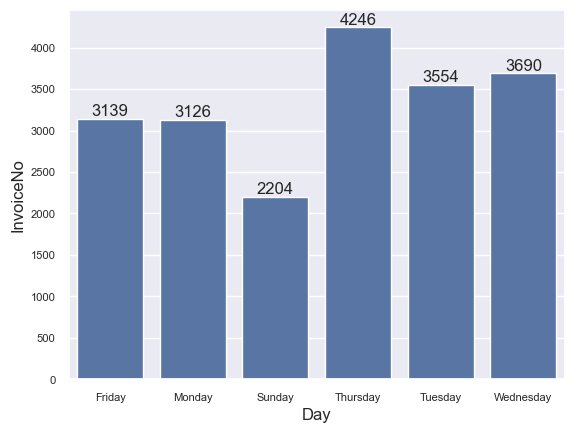

<Figure size 700x1500 with 0 Axes>

In [30]:
sns.set_theme(style="whitegrid")
sns.set()
a = sns.barplot(x='Day', y='InvoiceNo', data=grouped_day)
a.tick_params(labelsize=8)
a.bar_label(a.containers[0])
plt.figure(figsize = (7, 15))
plt.show()

Thursday has the highes invoice generation

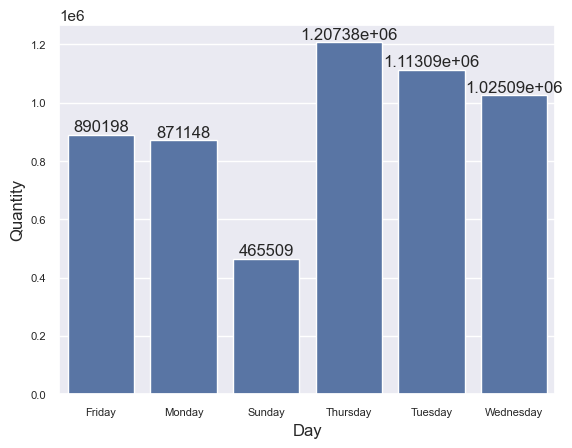

<Figure size 500x1500 with 0 Axes>

In [35]:
sns.set_theme(style="whitegrid")
sns.set()
a = sns.barplot(x='Day', y='Quantity', data=grouped_day)
a.tick_params(labelsize=8)
a.bar_label(a.containers[0])
plt.figure(figsize = (5, 15))
plt.show()

Thursday has the highest Quantity sale

## Identify Top Buyers

In [37]:
top_buyers = df[['CustomerID', 'InvoiceNo', 'Total_sales']].groupby(by=["CustomerID"]).sum().reset_index().sort_values(by='Total_sales', ascending=False).head(10)

In [38]:
df[['CustomerID', 'Country']].loc[df['CustomerID'].isin(top_buyers['CustomerID'])].drop_duplicates()

,CustomerID,Country
173,16029.0,United Kingdom
209,17511.0,United Kingdom
1357,14911.0,EIRE
1394,0.0,United Kingdom
6164,0.0,EIRE
6175,14156.0,EIRE
13594,17450.0,United Kingdom
15845,18102.0,United Kingdom
36671,14646.0,Netherlands
37029,0.0,Bahrain


## Correlation Analysis

In [23]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Time,Month,Day,Year,date,Total_sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,08:26:00,December,Wednesday,2010,2010-12-01,20.34


In [24]:
df_corr = df[['Quantity', 'UnitPrice', 'Country', 'Month', 'Day', 'Year','Total_sales']]
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524877 entries, 0 to 524876
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Quantity     524877 non-null  int64  
 1   UnitPrice    524877 non-null  float64
 2   Country      524877 non-null  object 
 3   Month        524877 non-null  object 
 4   Day          524877 non-null  object 
 5   Year         524877 non-null  int32  
 6   Total_sales  524877 non-null  float64
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 26.0+ MB


In [25]:
categorical_features = [col for col in df_corr.columns if df_corr[col].dtype=="object"]

X_corr = pd.get_dummies(df_corr, columns=categorical_features,dtype=int)

X_corr.head()

,Quantity,UnitPrice,Year,Total_sales,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,...,Month_May,Month_November,Month_October,Month_September,Day_Friday,Day_Monday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,6,2.55,2010,15.30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,6,3.39,2010,20.34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,8,2.75,2010,22.00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6,3.39,2010,20.34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6,3.39,2010,20.34,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


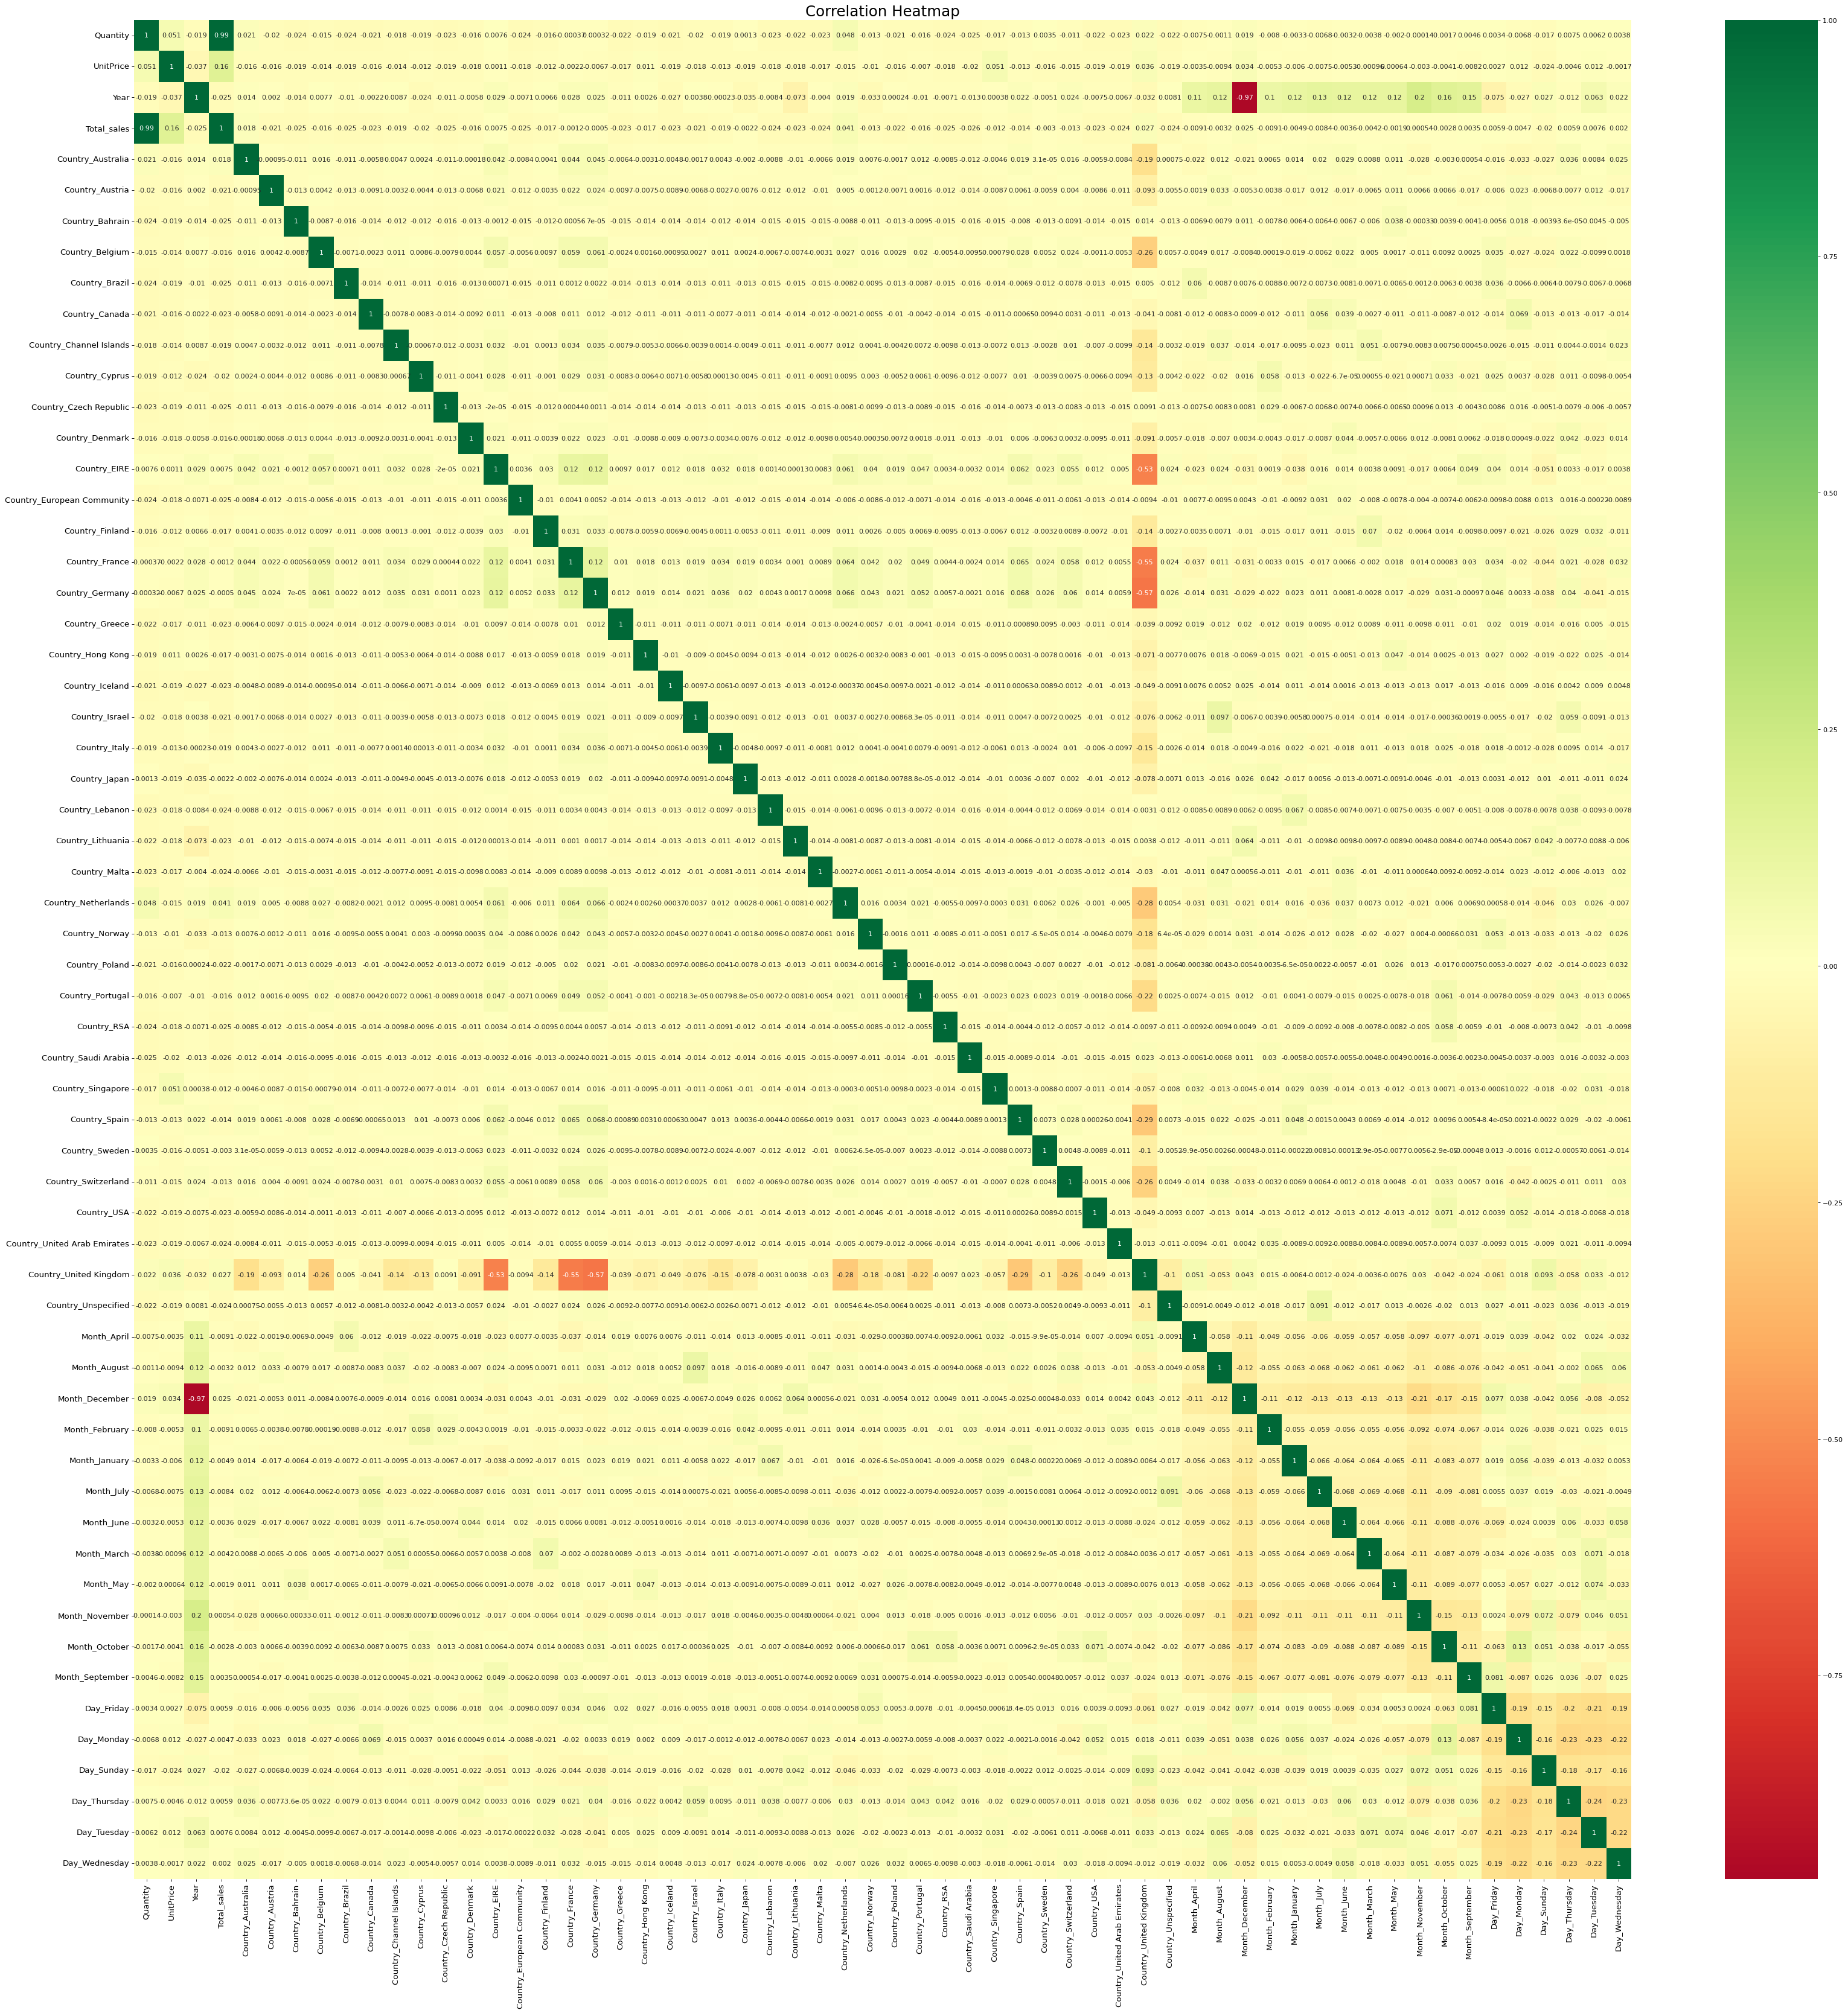

In [26]:
# Plot
corr = X_corr.corr()
plt.figure(figsize=(50,50), dpi= 80)
sns.heatmap(corr.corr(), xticklabels=corr.corr().columns, yticklabels=corr.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlation Heatmap', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [28]:
X_corr.to_csv("./data/categorical_managed_data.csv", index=False)